<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/mcliston_modeling/logistic_regression_Saturation_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit and Vegetable Classification
## \# Class activation heatmap for image classification
Taken from: https://www.kaggle.com/code/databeru/fruit-and-vegetable-classification

## \# Grad-CAM class activation visualization

Having 3861 images of 36 different fruits/vegetables

![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/feature_detection.ipynb)

<h1>Table of contents</h1>


<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

# Context

Image classification of fruits and vegetables has a wide range of applications in nutrition, cooking, farming, and produce wholesale. Being able to identify the type (fruit or vegetable) and class (which particular fruit or vegetable) is the foundational layer upon which one can build useful techniques related to produce such as quality evaluation, insect infestation, ripeness evaluation, sorting, recipe generation, and a myriad of others. Creating a well-performing baseline fruit and vegetable classifier opens up a world of possibilities for computer vision applications within the produce industry.

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

To balance the class distribution, we chose a subset of 10 of the 20 total vegetable classes. The following classes were analyzed as part of this project:

Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']



In [1]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
# Load the Drive helper and mount
#from google.colab import drive
import xarray as x

# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [2]:
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
mountdir = '/content/drive'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + '/MyDrive'
# Replace your folder here
w281_directory = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
inputdir = localdir + w281_directory
# Uncomment below if using local folder
# inputdir = "/Users/mcliston/Library/CloudStorage/GoogleDrive-michael.c.liston@gmail.com/My Drive/Berkeley/w281/Fruit-and-Vegetable-Classification/"

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import cv2
#import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

### Loading Training/Validation/Test sets

In [4]:
modeling_datasets = inputdir + 'modeling/'

In [5]:
!ls drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/train

train_hog_features.csv	      train_saturation_features.csv
train_hue_features.csv	      train_sobel_x_features.csv
train_laplacian_features.csv  train_sobel_y_features.csv
train_luminance_features.csv


In [6]:
train_saturation = pd.read_csv(modeling_datasets+'train/train_saturation_features.csv')
validation_saturation = pd.read_csv(modeling_datasets+'validation/validation_saturation_features.csv')
# test_saturation = pd.read_csv(modeling_datasets+'test/test_saturation_features.csv')

train_saturation = train_saturation.drop('Unnamed: 0', axis=1)
validation_saturation = validation_saturation.drop('Unnamed: 0', axis=1)
# test_saturation = test_saturation.drop('Unnamed: 0', axis=1)


##### Mapping labels to ints

In [7]:
unique_training_labels = set([i for i in train_saturation['label'].tolist()])
unique_val_labels = set([i for i in validation_saturation['label'].tolist()])
# unique_test_labels = set([i for i in test_saturation['label'].tolist()])

all_unique_labels = set(list(unique_training_labels) + list(unique_val_labels))
all_unique_labels = sorted(list(all_unique_labels))
label_numeric_mapping = {k:v for v,k in enumerate(all_unique_labels)}

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

from hyperopt import atpe, rand, tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate a simple plot of the learning curve.

    Parameters:
        estimator: The machine learning model or pipeline.
        title: The title of the plot.
        X: The feature matrix.
        y: The target vector.
        ylim: Tuple with (min, max) values to define the y-axis limits.
        cv: Cross-validation strategy. If None, 5-fold cross-validation is used.
        n_jobs: Number of jobs to run in parallel (-1 uses all available processors).
        train_sizes: Array of training set sizes to use for the learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="r",
        label="Training score",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="g",
        label="Cross-validation score",
    )
    plt.legend(loc="best")
    return plt


##### Bayesian Parameter Search

In [ ]:
# space = {
#             'penalty': hp.choice('penalty', ['l2']),
#             # 'fit_intercept' : hp.choice('fit_intercept', [True, False]),
#             'fit_intercept' : hp.choice('fit_intercept', [False]),
#             'tol': hp.choice('tol', [0.0001]),
#             # 'tol' : hp.uniform('tol', 0.00001, 0.0001),
#             'C' : hp.quniform('C', 0.05, 3, 0.05),
#             # 'C' : hp.uniform('C', 0.05, 3),
#             # 'C' : hp.choice('C', [1.0]),
#             # 'solver' : hp.choice('solver', ['newton-cg', 'sag', 'liblinear','saga']),
#             'solver' : 'liblinear',
#             'max_iter' : hp.choice('max_iter', [100]),
#             # 'max_iter' : hp.choice('max_iter', range(100,1000)),
#             # 'scale': hp.choice('scale', [0, 1]),
#             # 'warm_start' : hp.choice('warm_start', [True, False]),
#             'warm_start' : hp.choice('warm_start', [False]),
#             'multi_class' : 'ovr',
#             'class_weight' : 'balanced'
#                 }

space = {
    'C' : hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'fit_intercept' : hp.choice('fit_intercept', [True, False])
}

In [ ]:
def optimize_lr(params):

    skf = StratifiedKFold(n_splits=3)
    clf = LogisticRegression(**params, n_jobs=-1)
    f1_weighted = cross_val_score(clf, train_saturation.iloc[:, 0:-1], train_saturation['label'],
                         scoring=make_scorer(accuracy_score),
                        cv=skf).mean()
    best_score = np.mean(f1_weighted)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}

In [ ]:
RANDOM_SEED = 4321
trials = Trials()

best = fmin(
    fn=optimize_lr,
    space=space,
    algo=rand.suggest,
    # algo=atpe.suggest,
    # algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

100%|██████████| 10/10 [01:53<00:00, 11.32s/trial, best loss: 0.8210678210678211]
Best: {'C': 0.06410121535902825, 'fit_intercept': 0}


In [9]:
params = {'C': 0.06410121535902825}

saturation_model = LogisticRegression(**params, n_jobs=-1)
saturation_model.fit(train_saturation.iloc[:,0:-1], train_saturation['label'])

y_pred = saturation_model.predict(validation_saturation.iloc[:,0:-1])


In [10]:
accuracy_score(validation_saturation['label'], y_pred)

0.8116883116883117

In [11]:
print(classification_report(validation_saturation['label'], y_pred))

               precision    recall  f1-score   support

        apple       0.78      0.88      0.82         8
       banana       0.67      0.80      0.73         5
  bell pepper       0.71      1.00      0.83         5
      cabbage       0.75      0.86      0.80         7
  cauliflower       0.86      0.75      0.80         8
chilli pepper       0.78      1.00      0.88         7
         corn       0.70      0.78      0.74         9
       garlic       0.82      0.75      0.78        12
       ginger       0.80      0.80      0.80         5
       grapes       1.00      1.00      1.00        12
         kiwi       0.86      0.67      0.75         9
        mango       1.00      0.60      0.75        10
       orange       0.75      0.86      0.80         7
         pear       0.60      1.00      0.75         3
         peas       0.83      1.00      0.91         5
    pineapple       0.88      0.78      0.82         9
  pomegranate       0.88      0.78      0.82         9
      spi

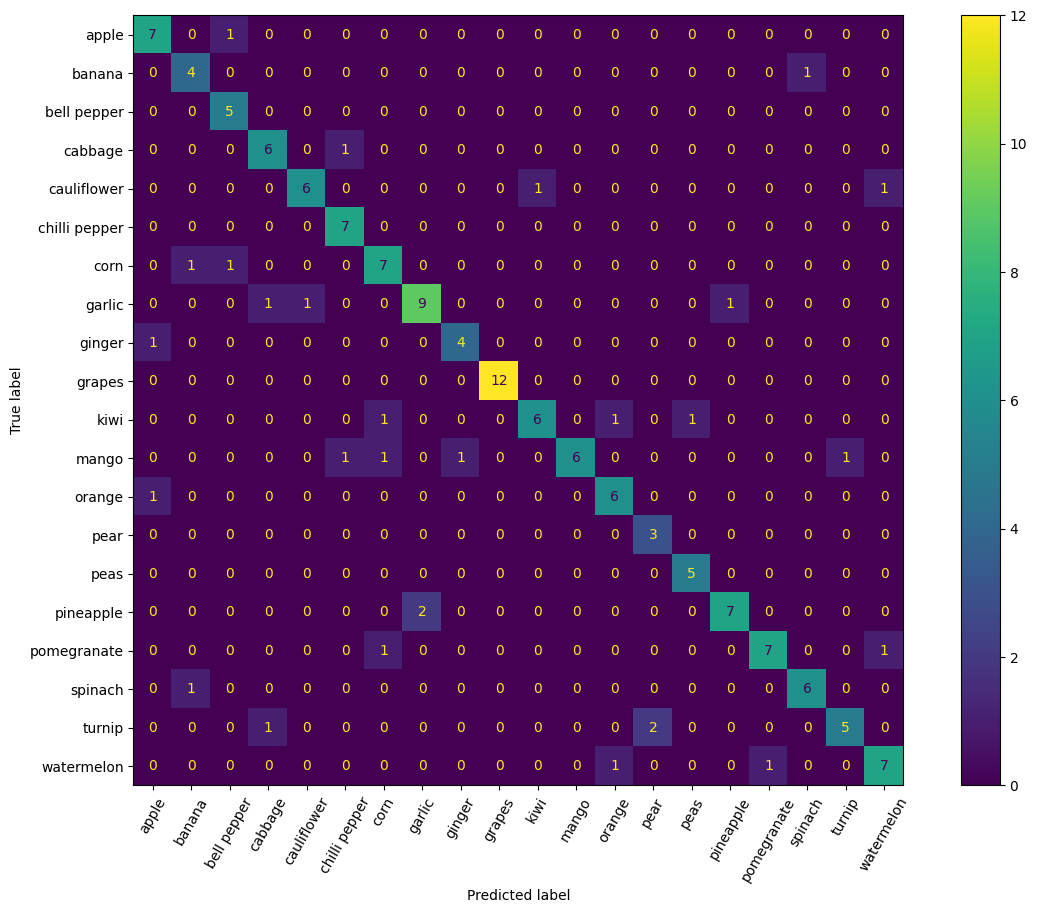

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(validation_saturation['label'], y_pred, xticks_rotation=60, ax=ax)

### Mis-classifications

#### Pineapple (True) vs. Garlic (Predicted)

In [14]:
for i,j in enumerate(zip(validation_saturation['label'].tolist(), y_pred)):
  if j[0] == 'pineapple' and j[1] == 'garlic':
    print(i)

31
89


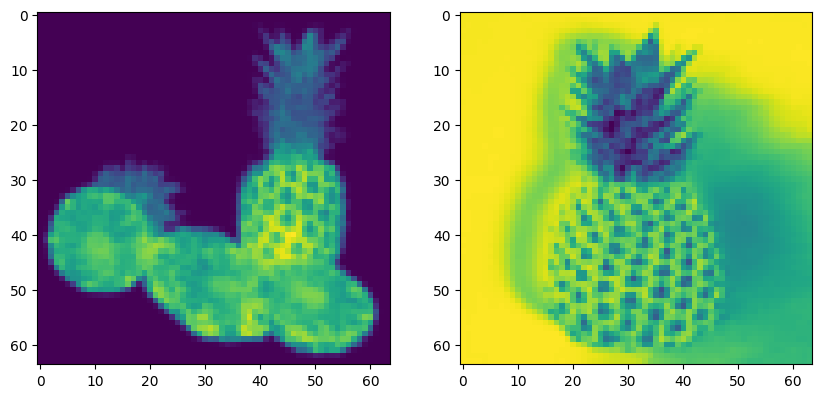

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(validation_saturation.iloc[31,0:-1].values.reshape((64,64)).astype(float))
ax[1].imshow(validation_saturation.iloc[89,0:-1].values.reshape((64,64)).astype(float))

In [17]:
import matplotlib
import random

def plot_sample(img_index_lst):

  fig = plt.figure(figsize=(15, 8))
  columns = 5
  rows = 2
  for i,j in zip(range(1, columns*rows +1),img_index_lst):
      img = train_saturation.iloc[j,0:-1].values.reshape((64,64)).astype(float)
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)

      matplotlib.rc('axes.spines',top=False,bottom=False,left=False,right=False);
      matplotlib.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
      matplotlib.rc(('xtick','ytick'),color=(1,1,1,0));

#### Training Pineapples...

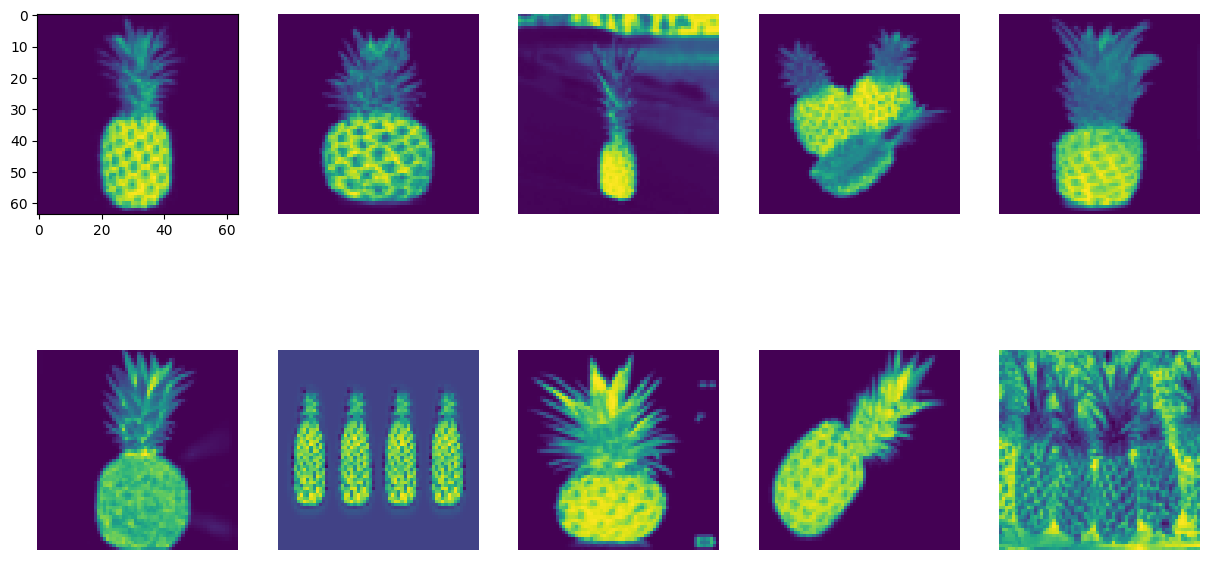

In [18]:
pineapple_index = []
for i,j in enumerate(train_saturation['label'].tolist()):
  if j == 'pineapple':
    pineapple_index.append(i)

plot_sample(pineapple_index)

#### Training Garlic...

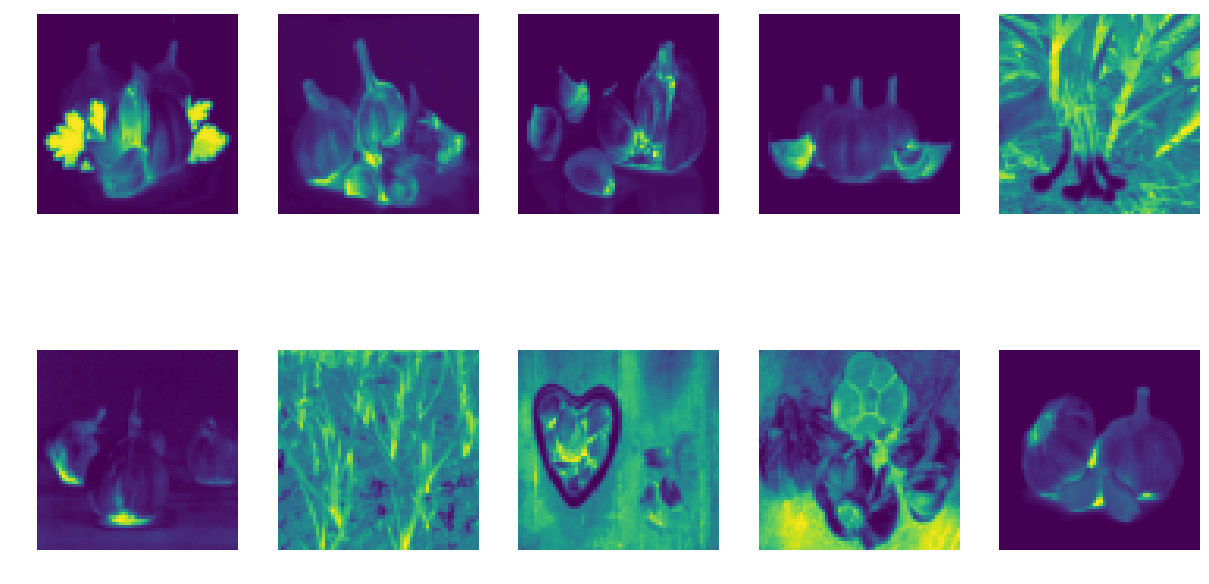

In [20]:
garlic_index = []
for i,j in enumerate(train_saturation['label'].tolist()):
  if j == 'garlic':
    garlic_index.append(i)

plot_sample(garlic_index)